In [2]:
# List of parameters

t_llc = 50 # cycles
N_inst_service = 8000
N_inst_rpc_stack = 5000
N_inst_Rpc_host = N_inst_rpc_stack + N_inst_service # 25/byte on ARM (from OP) + service 
l1_size = 32*1024 # 32KB
W = N_inst_Rpc_host * 4 #### FIXME: we measured 200KB for Compose Post (Aug. 6th), this number is closer to 50KB
blk_size = 64
arm_inst_width = 4 # bytes
N_nest = 3 # number of nested submessages

ns_per_cyc = 0.5

In [3]:
# Calculate rough number for running the RPC stack on the core

p_miss = (1-min(1,l1_size/W))/(blk_size/arm_inst_width)
    # miss calc = frac of instrs in L1 cache / (instructions/cache block)
CPI_core = 1 + p_miss*t_llc
MPKI = ((N_inst_Rpc_host) * p_miss) / (N_inst_Rpc_host/1000)
print("MPKI is:",MPKI)
    
mu_core = ((N_inst_Rpc_host * CPI_core) + (N_nest*t_llc))*ns_per_cyc
    # service time ~= (N_instr * CPI) + (nest msgs * LLC lat)
print('Service time for core-centric RPC stack:',mu_core,'ns')
print('Max throughput for single-core service (synchronous):',1/mu_core*1e9/1e3,'kRPS')

MPKI is: 23.115384615384617
Service time for core-centric RPC stack: 14087.5 ns
Max throughput for single-core service (synchronous): 70.9849157054126 kRPS


In [4]:
# Calculate rough number for running RPC stack on accelerator nic off-chip
# Assumptions:
    # incoming rpcs are completely transformed on-nic
    # single DMA for incoming buffer
    # pointers still point to physical space which is on-nic

t_pcie = 2000 # cycles. "Understanding PCIe performance for..." SIGCOMM'18, reports 256B transfer as 1000ns
C = 100 #### fixed cost of handling an incoming DMA
C_DMA = t_pcie + C

N_inst_Rpc_nic = N_inst_service
W_Rpc_nic = N_inst_Rpc_nic * 4
p_miss_nic = (1-min(1,l1_size/W_Rpc_nic))/(blk_size/arm_inst_width)
CPI_core_nic = 1 + p_miss_nic*t_llc

MPKI = ((N_inst_Rpc_nic) * p_miss_nic) / (N_inst_Rpc_nic/1000)
print("MPKI is:",MPKI)

mu_nic = ((N_inst_Rpc_nic * CPI_core_nic) + (N_nest * t_pcie) + C_DMA)*ns_per_cyc
#mu_nic = (C_DMA + N_nest*t_pcie)*ns_per_cyc
print('Service time for NIC-centric RPC stack:',mu_nic,'ns')
print('Max throughput for single-core service (synchronous):',1/mu_nic*1e9/1e3,'kRPS')

MPKI is: 0.0
Service time for NIC-centric RPC stack: 8050.0 ns
Max throughput for single-core service (synchronous): 124.22360248447205 kRPS


In [5]:
def calc_p_miss(cache_size,working_set):
    return (1-min(1,cache_size,working_set))/(blk_size/arm_inst_width)

def calc_servtime_corerpc(N_inst_host,num_nested_msgs):
    workset = N_inst_host * arm_inst_width
    p_miss = calc_p_miss(l1_size,workset)
    CPI = 1 + (p_miss*t_llc)
    
    return ((N_inst_host * CPI) + (num_nested_msgs*t_llc))*ns_per_cyc

def calc_servtime_nicrpc(N_inst_nic,num_nested_msgs,t_pcie):
    workset = N_inst_nic * arm_inst_width
    p_miss = calc_p_miss(l1_size,workset)
    CPI = 1 + (p_miss*t_llc)
    C_DMA = t_pcie + C
    
    return ((N_inst_nic * CPI) + (num_nested_msgs * t_pcie) + C_DMA)*ns_per_cyc
    

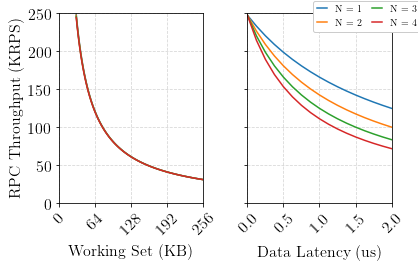

In [6]:
# Generate plots
import matplotlib.pyplot as plt
import numpy
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages

#fontdir = {'size':16,'family':'serif','serif':'Palatino'}
fontdir = {'size':16,'family':'serif'}
rc('font',**fontdir)
rc('text',usetex=True)

# Independent vars for core-based stack: 
    # num instructions in the rpc stack
    # num nested messages
    
nested_range = numpy.arange(1,5,1,)
instr_range = numpy.arange(0,60000,500)
pcie_range = numpy.arange(0,4500,250)

# convert number of instrs to code footprint
code_size = list(map( lambda x : (((x+N_inst_service)*4)/1024), instr_range ))

with PdfPages('rpc_throughput_comparison.pdf') as pp:
    f,axarr = plt.subplots(1,2,sharey=True)

    YVals_Core = {}
    YVals_NIC = {}

    def conv_to_krps(stime_ns):
        rps = 1/(stime_ns*1e-9)
        return rps/1e3

    # for all nested counts
    for i in nested_range:
        stimes_core = map( lambda x : calc_servtime_corerpc(x+N_inst_service,i), instr_range )
        krps_core = map( lambda x : conv_to_krps(x), stimes_core)
        YVals_Core[i] = list(krps_core)

        stimes_nic = map( lambda y : calc_servtime_nicrpc(N_inst_service,i,y), pcie_range)
        krps_nic = map( lambda x : conv_to_krps(x), stimes_nic)
        YVals_NIC[i] = list(krps_nic)
        #YVals_Core[i] = list(map( lambda x : calc_servtime_corerpc(x+N_inst_service,i), instr_range ))
        #YVals_NIC[i] = list(map( lambda y : calc_servtime_nicrpc(N_inst_service,i,y), pcie_range))

    # Plot all values on both subplots
    for k,v in YVals_Core.items():
        l = 'N = ' + str(k)
        axarr[0].plot(code_size,v,label=l)

    us_pcies = list(map(lambda x : x*ns_per_cyc/1000, pcie_range))
    for k,series in YVals_NIC.items():
        l = 'N = ' + str(k)
        axarr[1].plot(us_pcies,series,label=l)

    # Config plots
    from matplotlib.ticker import FormatStrFormatter
    for i,ax in enumerate(axarr):
        ax.tick_params(labelsize=16)
        ax.tick_params(axis='x',labelrotation=45)
        ax.grid(True,axis='both',linestyle='--',alpha=0.5)
        ax.set_ylim(0,250)
        if i == 0:
            ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
        else: 
            ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    
    handles, labels = axarr[1].get_legend_handles_labels()

    axarr[0].set_ylabel('RPC Throughput (KRPS)')
    axarr[0].set_xlabel('Working Set (KB)')
    axarr[0].set_xticks(numpy.linspace(0,256,5))
    axarr[0].set_xlim(0,256)
    axarr[1].set_xlim(0,2)
    axarr[1].set_xticks(numpy.linspace(0,2,5))
    axarr[1].set_xlabel('Data Latency (us)',labelpad=7)
    f.legend(handles,labels,loc='lower center',bbox_to_anchor=(0.85,0.8),ncol=2,fontsize=10,frameon=True,framealpha=1,
            handlelength=1,columnspacing=1)
    f.tight_layout()
    pp.savefig()